# Tarea INFO286: Minería de Procesos

Integrantes: Felipe Córdova y Javier Reyes  
Profesor: Juan Salazar  
Fecha: 09/05/2025  


## Resumen

En este trabajo se analiza el log de eventos `traffic_fines`, el cual representa el proceso de gestión de multas de tránsito en Italia. Se utilizaron herramientas del ecosistema `bupaR` en R para explorar el log, visualizar el proceso, responder preguntas específicas y proponer mejoras. Se identificaron cuellos de botella, variantes comunes y actividades críticas. Entre los principales hallazgos destacan demoras considerables en ciertas etapas y la existencia de múltiples variantes del proceso. Se proponen dos mejoras orientadas a reducir tiempos muertos y simplificar el flujo de actividades.


### Instalación y carga de paquetes

In [14]:
# Instalar los paquetes solo la primera vez:
# install.packages("bupaR")
# install.packages("eventdataR")  # contiene el log traffic_fines
# install.packages("edeaR")       # análisis exploratorio
# install.packages("processmapR") # mapas de proceso
# install.packages("processmonitR") # monitoreo
# install.packages("DiagrammeR")

# Cargar los paquetes:
library(bupaR)
library(eventdataR)
library(edeaR)
library(processmapR)
library(processmonitR)
library(ggplot2)
library(DiagrammeR)

### Cargar el log *traffic_fines*

In [15]:
data("traffic_fines")

## 1. Descripción general del log

En esta sección se realiza una revisión exploratoria de los datos del proceso, identificando aspectos clave como la cantidad de casos, el número de actividades distintas, las ventanas de tiempo involucradas, la duración de los casos, la cantidad y distribución de variantes, así como los participantes que intervienen en el proceso.

Dado que el log ya ha sido cargado, procedemos a presentar un resumen general de los datos.

In [16]:
# Resumen general del log
summary(traffic_fines)

Number of events:  34724
Number of cases:  10000
Number of traces:  44
Number of distinct activities:  11
Average trace length:  3.4724

Start eventlog:  2006-06-17
End eventlog:  2012-03-26



   case_id                                activity        lifecycle    
 Length:34724       Create Fine               :10000   complete:34724  
 Class :character   Send Fine                 : 6570                   
 Mode  :character   Payment                   : 4910                   
                    Add penalty               : 4635                   
                    Insert Fine Notification  : 4635                   
                    Send for Credit Collection: 3387                   
                    (Other)                   :  587                   
    resource       timestamp                         amount         
 559    : 1278   Min.   :2006-06-17 00:00:00.00   Length:34724      
 557    : 1181   1st Qu.:2007-07-19 00:00:00.00   Class :character  
 541    : 1119   Median :2007-10-29 00:00:00.00   Mode  :character  
 561    : 1002   Mean   :2007-12-06 15:34:51.32                     
 558    :  948   3rd Qu.:2008-02-29 00:00:00.00                     
 (Other): 

Algunos de los datos solicitados pueden observarse en el resumen general obtenido previamente mediante la función `summary(data)` en R. Sin embargo, a continuación se presentan algunos comandos específicos de la librería bupaR que permiten visualizar esta información de manera más clara y detallada.

In [17]:
# Número de casos
n_cases(traffic_fines)

[1] 10000

In [18]:
# Número de actividades distintas
n_activities(traffic_fines)

[1] 11

In [19]:
# Ver el nombre de las 11 actividades
activities(traffic_fines)

activity,absolute_frequency,relative_frequency
<fct>,<int>,<dbl>
Create Fine,10000,0.287985255
Send Fine,6570,0.189206313
Payment,4910,0.141400760
Add penalty,4635,0.133481166
Insert Fine Notification,4635,0.133481166
Send for Credit Collection,3387,0.097540606
Insert Date Appeal to Prefecture,232,0.006681258
Send Appeal to Prefecture,227,0.006537265
Receive Result Appeal from Prefecture,55,0.001583919


In [20]:
# Ventana de tiempo que abarca
start_time <- min(traffic_fines$timestamp)
end_time <- max(traffic_fines$timestamp)
start_time
end_time

[1] "2006-06-17 UTC"

[1] "2012-03-26 UTC"

In [21]:
# Duración de los casos (tiempo total de ejecución de los casos)
throughput_time(traffic_fines, units="days")

# Duración de los casos (tiempo de cada caso individual)
# throughput_time(traffic_fines, units = "days", level = "case")

min,q1,median,mean,q3,max,st_dev,iqr
<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<dbl>,<drtn>
0 days,7 days,125 days,296.1351 days,596 days,1956 days,313.2794,589 days


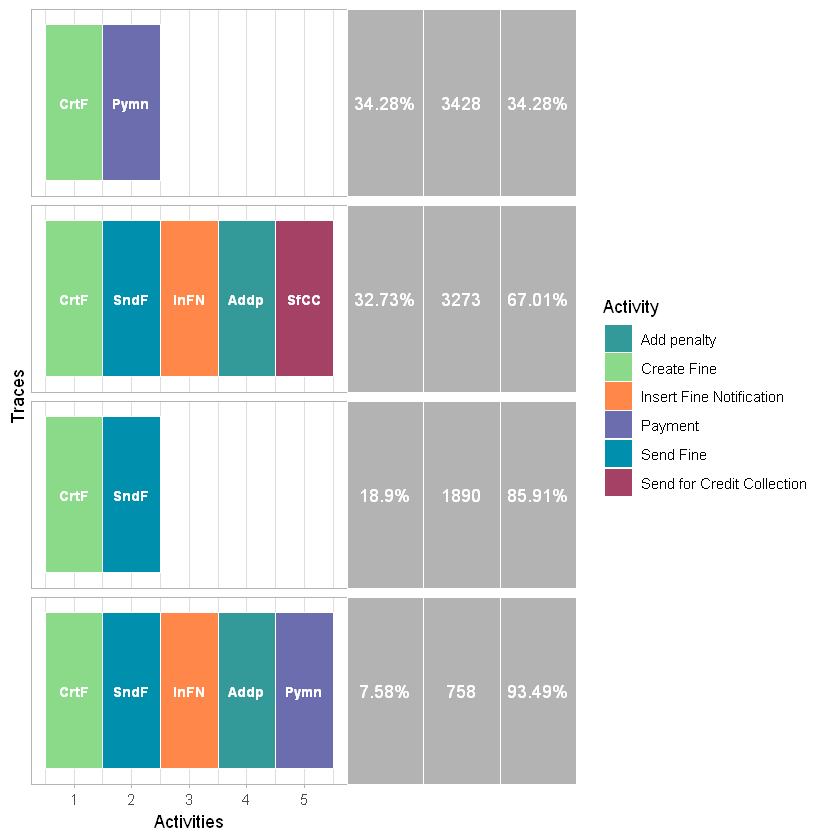

In [22]:
# Distribución de variantes al 90% de los casos
trace_explorer(traffic_fines, coverage = 0.9)


In [23]:
# Personas que participan en el proceso en %
resource_frequency(traffic_fines, level = "resource") %>%
  mutate(percentage = absolute / sum(absolute) * 100)


resource,absolute,relative,percentage
<fct>,<int>,<dbl>,<dbl>
NA,24705,0.7114675729,71.14675729
559,1278,0.0368045156,3.68045156
557,1181,0.0340110586,3.40110586
541,1119,0.0322255501,3.22255501
561,1002,0.0288561226,2.88561226
558,948,0.0273010022,2.73010022
537,946,0.0272434051,2.72434051
564,602,0.0173367124,1.73367124
556,600,0.0172791153,1.72791153


### Descripción General 

| Información | Cantidad | 
| :--| :-- |
| Número de casos |  10000 casos |
| Número de actividades únicas | 11 actividades |
| Ventana de tiempo | [2006-06-17, 2012-03-26] |
| Duración de los casos | En promedio 296.1351 días |
| Cantidad de variantes | 44 variantes (traces) |
| Distribución de variantes | A pesar de que el log contiene 44 variantes distintas, solo 4 de ellas concentran prácticamente el 93.49% de los casos. La variante más frecuente representa por sí sola el 34.28% de los casos, seguida de tres variantes con 32.73%, 18.9% y 7.58%, respectivamente. Esto indica que, aunque hay una diversidad considerable de secuencias, la mayoría de los casos sigue un conjunto muy limitado de rutas de proceso. |
| Personas / Roles que participan | Se identifican los siguientes id: 561 / 537 / 550 / 541 / 557 / 558 / 559 / 0 / 536 / 560 / 562 / 563 / 564 / 556 / 538. Pero, 24705 eventos o actividades no tienen una persona específicamente asignada (persona no registrada NA)| 
| Con qué información se cuenta | Los procesos empiezan con **Create Fine** y terminan con: **Payment**, **Send for Credit Collection** y **Send Fine**. Pueden ser finalizados por diferentes roles según el resultado: **Payment** implica resolución por parte del ciudadano, mientras que **Send for Credit Collection** y **Send Fine** corresponden a acciones administrativas posteriores por parte de la autoridad. |
| Con qué información no se cuenta | No se cuenta con detalles sobre el tipo de infracción ni el monto de la multa, lo que limita el análisis según gravedad. Tampoco hay información sobre el vehículo ni el contexto del hecho, lo que impide evaluar patrones específicos o reincidencias. |

## 2. Análisis de diagrama del proceso

Para crear el diagrama de procesos, debido a algunos inconvenientes técnicos, no fue posible visualizar el diagrama utilizando únicamente el comando `process_map()`. Aunque la ejecución era correcta, el resultado no se mostraba en la consola de Jupyter Notebook. Por lo tanto, se utilizó la librería `DiagrammeR` (cargada al inicio) junto con un widget HTML para poder visualizar el diagrama en el navegador. Una vez hecho esto, se procedió a tomar una captura de pantalla y guardar el diagrama bajo el nombre `diagrama_proceso.png` en la carpeta **imagenes**. Además, se creó un archivo `.gitignore` para evitar que se suban las carpetas generadas durante la creación del gráfico y del archivo HTML. Se deja comentado el código utilizado para evidencia.

In [24]:
# Diagrama de procesos clásico
# graph <- process_map(traffic_fines)

# Guardar como HTML
# htmlwidgets::saveWidget(graph, "proceso_traffic_fines.html")

A continuación se presenta la imagen.  

![Diagrama del proceso](./imagenes/diagrama_proceso.png)


Como se puede observar en la imagen, así como en el gráfico presentado en la Sección 1 sobre la distribución de variantes que abarcan el 90% del total de casos, las principales variantes del proceso corresponden a aquellas que presentan un color más intenso y flechas de mayor grosor. Tal como se explicó en clases, esto indica una mayor frecuencia de ocurrencia. A medida que disminuye la intensidad del color, también lo hace la frecuencia relativa de la variante.  

Entre las variantes más representativas del proceso, se identifican las siguientes secuencias:

1. **Start** → `Create Fine` → `Payment` → **END**  
2. **Start** → `Create Fine` → `Send Fine` → `Insert Fine Notification` → `Add penalty` → `Send for Credit Collection` → **END**  
3. **Start** → `Create Fine` → `Send Fine` → **END**  
4. **Start** → `Create Fine` → `Send Fine` → `Insert Fine Notification` → `Add penalty` → `Payment` → **END**  

Este diagrama se complementa adecuadamente con el análisis realizado mediante el comando activities(traffic_fines), presentado en la Sección 1, donde se identifican las once actividades que conforman el proceso. En dicho análisis también se observa la frecuencia absoluta de cada actividad, lo que permite comprender en mayor profundidad la estructura y dinámica del flujo de eventos.

| Actividad | Frecuencia | 
| :--| :-- |
| Create Fine |  10000 |
| Send Fine | 6570 |
| Payment | 4910 |
| Add penalty | 4635 |
| Insert Fine Notification | 4635 |
| Send for Credict Collection | 3387 |
| Insert Date Appeal to Prefecture | 232 |
| Send Appeal to Prefecture | 227 |
| Receive Result Appeal from Prefecture | 55 |
| Notify Result Appeal to Offender | 54 |
| Appeal to Judge | 19 |




Al igual que anteriormente, para visualizar el diagrama de demoras se utilizó DiagrammeR junto con visualización en HTML, debido a las limitaciones de Jupyter Notebook. La imagen fue capturada y guardada en la carpeta de **imagenes** como `diagrama_demoras.png`, y se deja el código utilizado como evidencia.

In [25]:
# Mapa con tiempo promedio entre actividades en dias
# graph <- process_map(traffic_fines, performance(median, "days"))

# Guardar como HTML
# htmlwidgets::saveWidget(graph, "proceso_traffic_fines_times.html")

A continuación se presenta la imagen mencionada. En estas transiciones, destacadas en color amarillo, representan los mayores tiempos de espera entre actividades.


![Diagrama de demoras](./imagenes/diagrama_demoras.png)


Como se observa en la imagen, se identifican cinco demoras principales en el proceso, las cuales se resumen en el gráfico de barras elaborado en R, a continuación:

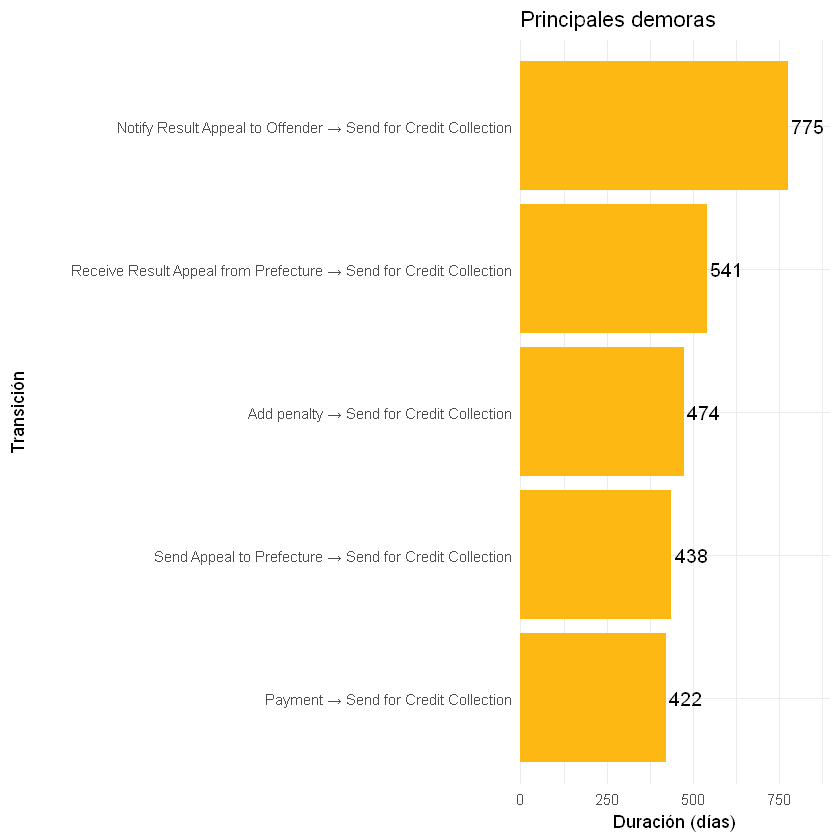

In [26]:
# Crear un data frame con las demoras
demoras <- data.frame(
  transicion = c(
    "Notify Result Appeal to Offender → Send for Credit Collection",
    "Receive Result Appeal from Prefecture → Send for Credit Collection",
    "Add penalty → Send for Credit Collection",
    "Send Appeal to Prefecture → Send for Credit Collection",
    "Payment → Send for Credit Collection"
  ),
  dias = c(775, 541, 474, 438, 422)
)

# Graficar con etiquetas y espacio adicional
ggplot(demoras, aes(x = reorder(transicion, dias), y = dias)) +
  geom_bar(stat = "identity", fill = "#FDB813") +
  geom_text(aes(label = dias), hjust = -0.1, size = 4) +  # Etiquetas fuera de la barra
  coord_flip() +
  labs(title = "Principales demoras",
       x = "Transición",
       y = "Duración (días)") +
  theme_minimal() +
  scale_y_continuous(expand = expansion(mult = c(0, 0.16)))  # espacio extra a la derecha


Estas demoras podrían reflejar ineficiencias en la comunicación y seguimiento entre etapas. La mayor demora es de 775 días (aproximadamente 2 años y 1 mes), lo cual representa un tiempo excesivo. Optimizar estas áreas podría reducir significativamente la duración total del proceso.

En el primer diagrama de procesos presentado en esta sección, podemos ver que en el estado END, llegan 6 flechas, lo cual podemos decir que 6 variantes inician y terminan de manera correcta.

Estas son:




## 3. Análisis del log mediante preguntas


## 4. Propuesta de mejoras al proceso


## Conclusión

Resumen de lo aprendido, limitaciones y posibles mejoras futuras del análisis.
